# Lotka-Volterra toy model

The [LotkaVolterraModel](http://pints.readthedocs.io/en/latest/toy/lotka_volterra_model.html) describes the relationship between two interacting species, where one preys on the other. A good description of its history and interpretation can be found on [Wikipedia](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

The model has 2 states $x$ and $y$, where $x$ represents a population of prey, and $y$ represents a population of predators.
It is described by the ODEs:

$$ \frac{dx}{dt} = ax - bxy $$

and

$$ \frac{dy}{dt} = -cy + dxy $$

where $a, b, c$, and $d$ are the four model parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pints
import pints.toy

model = pints.toy.LotkaVolterraModel()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 2
Parameters: 4


We can get some suggested parameters and plot some data!

[3 2 3 2]


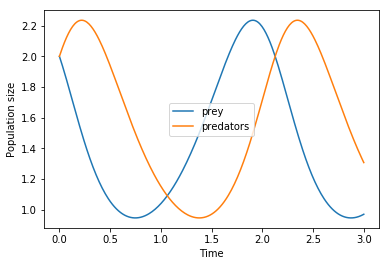

In [2]:
times = model.suggested_times()
parameters = model.suggested_parameters()
print(parameters)

plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, model.simulate(parameters, times))
plt.legend(['prey', 'predators'])
plt.show()

In this set-up, the first state represents the prey, and the second the predators.
When there is no prey, the predators begin to die out, which allows the prey population to recover.

To show the cyclical nature more clearly, these two populations are often plotted against each other:

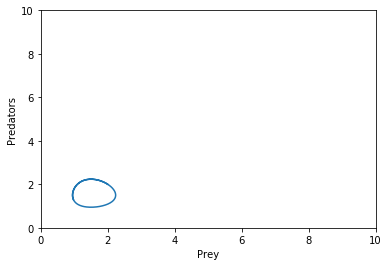

In [3]:
values = model.simulate(parameters, times)

plt.figure()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('Prey')
plt.ylabel('Predators')
plt.plot(values[:, 0], values[:, 1])
plt.show()

We can explore the model further by varying the initial conditions:

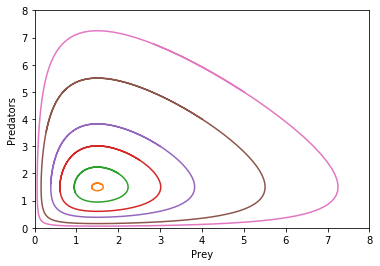

In [4]:
plt.figure()
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.xlabel('Prey')
plt.ylabel('Predators')

for x in [1.5, 1.6, 2, 2.5, 3, 4, 5]:
    model.set_initial_conditions([x, x])
    values = model.simulate(parameters, times)
    plt.plot(values[:, 0], values[:, 1])
plt.show()

To see how sensitive the system is to different parameters, we can set up and run an MCMC routine:

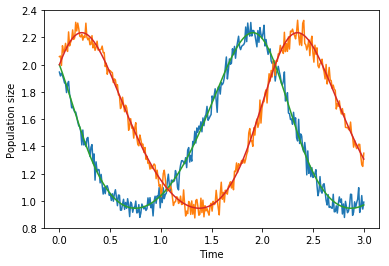

In [5]:
model.set_initial_conditions([2, 2])
values = model.simulate(parameters, times)
sigma = 0.05
noisy_values = values + np.random.normal(0, sigma, values.shape)

plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, noisy_values)
plt.plot(times, values)
plt.show()

In [6]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, noisy_values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 1, 1], [6, 6, 6, 6])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, sigma)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[4, 1, 2, 3]]*3
mcmc = pints.MCMCSampling(log_posterior, 3, x0)
mcmc.set_max_iterations(4000)
#mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.667     0          0:00.0
3     12     0.25      0.5       0          0:00.0
20    63     0.381     0.524     0.286      0:00.1
40    123    0.439     0.415     0.415      0:00.2
60    183    0.377     0.344     0.377      0:00.2
80    243    0.321     0.333     0.296      0:00.3
100   303    0.257     0.297     0.238      0:00.3
120   363    0.214876  0.273     0.198      0:00.4
140   423    0.184     0.234     0.17       0:00.5
160   483    0.161     0.205     0.149      0:00.5
180   543    0.144     0.188     0.133      0:00.6
Initial phase completed.
200   603    0.129     0.174     0.119403   0:00.7
220   663    0.127     0.172     0.122      0:00.7
240   723    0.133     0.191     0.129      0:00.8
260   783    0.176  

3160  9483   0.224     0.232     0.227      0:11.5
3180  9543   0.224     0.231     0.226      0:11.6
3200  9603   0.225     0.231     0.226      0:11.6
3220  9663   0.226     0.231     0.226      0:11.7
3240  9723   0.226     0.232     0.226      0:11.8
3260  9783   0.225391  0.232     0.227      0:11.9
3280  9843   0.226     0.232     0.227      0:12.0
3300  9903   0.226     0.231445  0.227      0:12.1
3320  9963   0.225     0.231     0.228      0:12.1
3340  10023  0.224     0.232     0.228      0:12.2
3360  10083  0.224     0.232     0.228801   0:12.3
3380  10143  0.224     0.232     0.229      0:12.3
3400  10203  0.224     0.233     0.229      0:12.4
3420  10263  0.224     0.234     0.228      0:12.5
3440  10323  0.224     0.233653  0.227      0:12.5
3460  10383  0.223     0.235     0.227102   0:12.6
3480  10443  0.223     0.235     0.227      0:12.6
3500  10503  0.222     0.235647  0.228      0:12.7
3520  10563  0.222096  0.235     0.228      0:12.8
3540  10623  0.223     0.235   

R-hat:
[1.078403673118607, 1.0477124994282836, 1.0651132349574168, 1.0629509070339487]


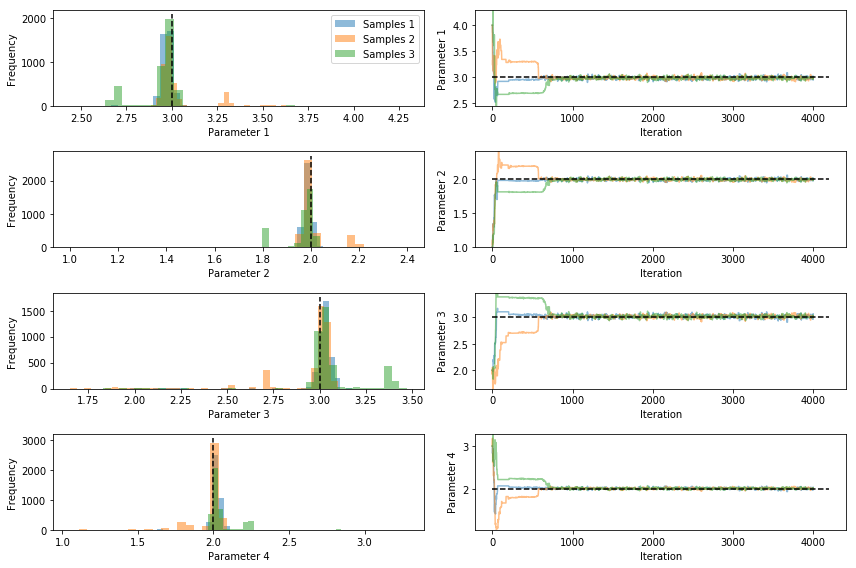

In [7]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

import pints.plot
pints.plot.trace(chains, ref_parameters=parameters)
plt.show()

We can also compare the predictions with these values to what we found:

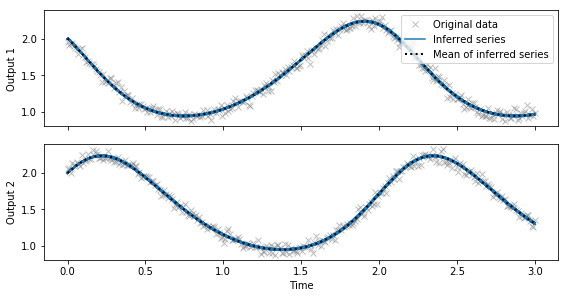

In [8]:
# Select first chain
chain1 = chains[0]

# Remove burn-in
chain1 = chain1[2500:]

# Plot some predictions with these samples
pints.plot.series(chain1, problem)
plt.show()